# 20231112 장보경 코드
## 사용한 코드
- 기존 캐글 노트북 코드 https://www.kaggle.com/code/khyeh0719/ptb-xl-dataset-wrangling
- 멘토님께서 주신 PTB 가이드라인 코드파일

## 공부내용
- 캐글 코드에 한국어 주석 처리 + 설명 + 시각화 아웃풋 캡쳐본 추가
- 가이드라인의 내용과 노트북 내용 비교

# EDA

In [ ]:
# 필요한 라이브러리를 임포트합니다.
import pandas as pd  # 데이터 조작 및 분석을 위한 라이브러리
import numpy as np  # 수치 계산을 위한 라이브러리
import wfdb  # 심전도 데이터를 읽기 위한 라이브러리
import ast  # 문자열 형태의 파이썬 표현식을 파싱하기 위한 라이브러리
from tqdm import tqdm  # 반복 작업의 진행 상황을 시각적으로 표시하기 위한 라이브러리
import warnings; warnings.filterwarnings('ignore')  # 경고 메시지를 무시하기 위한 설정
from IPython.display import display  # Jupyter 노트북에서 데이터를 깔끔하게 보여주기 위한 함수

# 데이터 시각화를 위한 라이브러리를 임포트합니다.
import matplotlib.pyplot as plt  # 그래프를 그리기 위한 라이브러리
import seaborn as sns  # matplotlib 기반의 고급 시각화 라이브러리
%matplotlib inline  # 노트북 안에서 그래프를 바로 볼 수 있게 설정

## Load Raw Data

In [ ]:
# 원시 심전도 데이터를 로드하는 함수를 정의합니다.
def load_raw_data(df, sampling_rate, path):
    # 샘플링 레이트에 따라 로드할 파일을 결정합니다.
    if sampling_rate == 100:
        # tqdm을 사용하여 진행 상황을 시각적으로 표시하면서 낮은 해상도 데이터를 로드합니다.
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        # tqdm을 사용하여 진행 상황을 시각적으로 표시하면서 높은 해상도 데이터를 로드합니다.
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    # 읽어온 데이터에서 신호 부분만 추출하여 넘파이 배열로 변환합니다.
    data = np.array([signal for signal, meta in data])
    return data

wfdb.rdsamp 함수는 
- path와 결합된 각 파일명에 대해 호출되어 심전도 데이터를 로드합니다. 
- 신호 데이터와 메타데이터를 튜플로 반환합니다.

위 코드는 다수의 파일로부터 심전도 데이터를 효율적으로 로드하고, 이를 분석이나 딥러닝 모델 학습에 바로 사용할 수 있는 형태로 만들기 위한 전처리 단계입니다.

In [ ]:
# 데이터 경로를 설정합니다.
path = '../input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

# 샘플링 레이트를 설정합니다. 여기서는 100Hz를 사용합니다.
sampling_rate=100

# 메타데이터를 로드하고 전처리합니다.

Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

# scp_codes 컬럼의 문자열을 파이썬 딕셔너리로 변환합니다. (중요)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))  

# 앞서 정의한 함수를 사용하여 원시 신호 데이터를 로드합니다.
X = load_raw_data(Y, sampling_rate, path)

print('data shape:', X.shape) # data shape: (21837, 1000, 12)
Y[['scp_codes']]
Y 

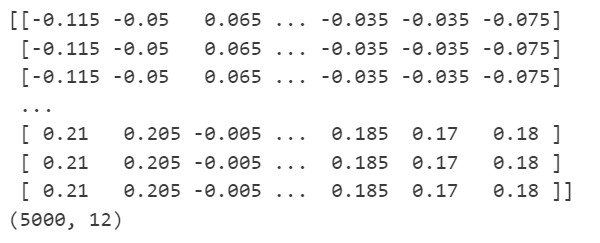

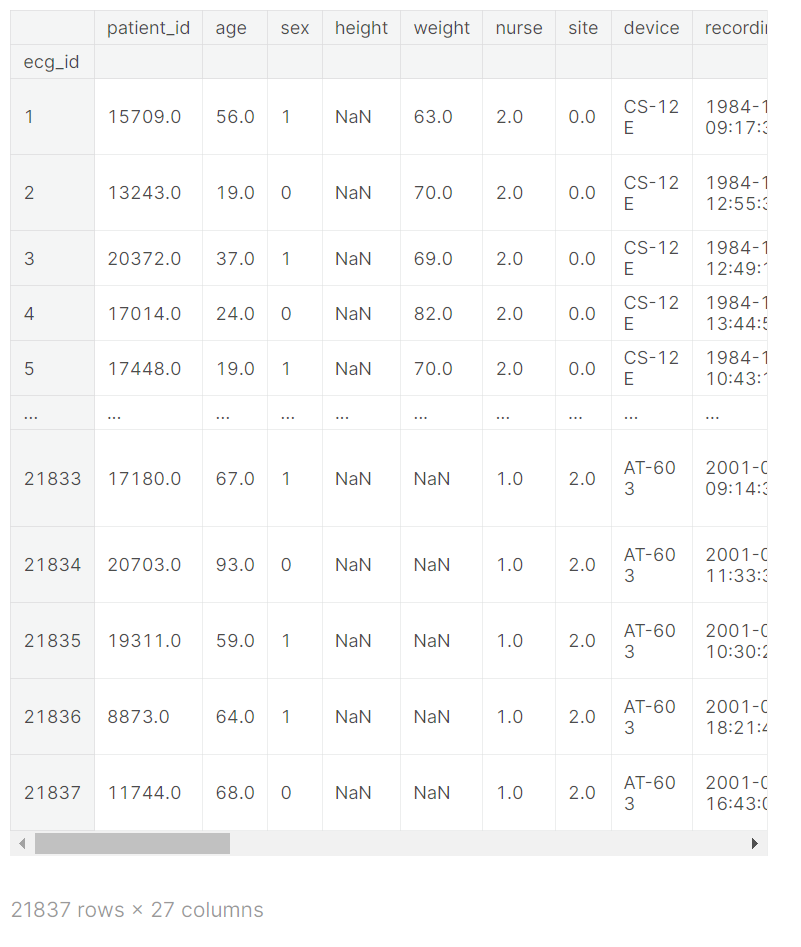

- scp_codes 컬럼에 있는 문자열을 ast.literal_eval 함수를 사용하여 안전하게 파이썬 딕셔너리로 변환합니다. 이 컬럼은 심전도 데이터에 대한 진단 코드를 포함하고 있으며, 문자열로 저장되어 있습니다.
- load_raw_data 함수를 호출하여 원시 신호 데이터를 로드합니다. 이 함수는 앞서 정의한 대로 실제 심전도 신호를 넘파이 배열 형태로 변환합니다.

### 우리팀에서는

- 500Hz 고해상도 데이터 사용 예정임. 

- 12개의 Lead 데이터라고 불리는데, 각 Lead의 이름은 다음과 같습니다.
        - 'I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'
- 이 가운데, 우리는 Lead I 을 사용할 것입니다. 이는 갤럭시 워치나 애플 워치와 같이 두 팔에서 수집된 신호 데이터 입니다.
- 따라서, 5000x12 shape의 array에서 Lead I에 해당되는 5000개의 데이터만 저장해서 최종 저장 데이터 array의 shape은 (N, 5000)이 되어야 함.

## Load Data for Heart Beat Diagnostic 
- 이 단계는 데이터 분석에서 중요한 진단 코드를 선별하고, 이를 이용하여 데이터셋 내의 각 심전도 레코드가 어떤 진단적 특성을 가지는지 파악하는 데 필요합니다. 이 정보는 후에 심전도 데이터의 레이블로 사용되거나, 데이터를 더 잘 이해하기 위한 탐색적 데이터 분석에 활용될 수 있습니다.

In [ ]:
# SCP-ECG 진단 파일을 로드합니다.
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

# diagnostic 컬럼 값이 1인 행만 선택합니다. 1 외에는 비어있는 행만 있음.
agg_df = agg_df[agg_df.diagnostic == 1]

print(agg_df.shape) # (44, 12)
agg_df.head()

- 아래 과정을 통해 각 심전도 레코드가 여러 상위 진단 클래스에 속할 수 있는지 파악하고, 다중 라벨 분류 문제에 대한 이해를 돕거나, 후속 분석 및 모델링 작업을 위한 데이터 준비를 합니다.

In [ ]:
# SCP-ECG 진단 코드를 상위 클래스로 집계하는 함수를 정의합니다.
def aggregate_supclass_diagnostic(y_dic):
    tmp = []  
    for key in y_dic.keys():  # 주어진 진단 코드의 키들을 순회합니다.
        if key in agg_df.index:  # 만약 키가 agg_df의 인덱스에 존재한다면,
            # 해당 진단 코드의 상위 클래스를 임시 리스트에 추가합니다.
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))  # 중복을 제거한 리스트를 반환합니다.
    
# 각 심전도 레코드에 대한 진단 코드를 상위 클래스로 집계하여 새로운 컬럼에 저장합니다.
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_supclass_diagnostic)

# 각 레코드의 상위 진단 클래스 개수를 저장하는 새로운 컬럼을 추가합니다.
Y['diagnostic_superclass_len'] = Y['diagnostic_superclass'].apply(len)

# 상위 진단 클래스가 여러 개인 레코드를 선택하여 출력합니다.
Y.loc[Y.diagnostic_superclass_len > 1, 'diagnostic_superclass']

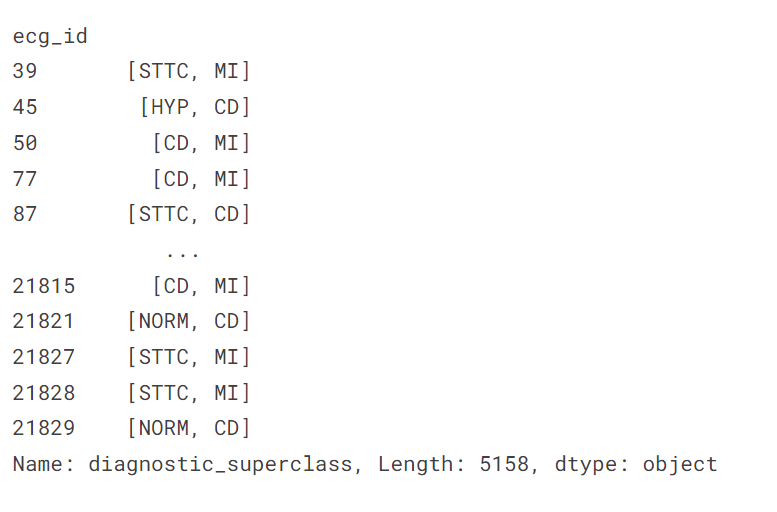

### Number of Superclass per ECG record

In [ ]:
# 상위 진단 클래스 개수에 대한 값의 분포를 구합니다.
vc = Y['diagnostic_superclass_len'].value_counts()

# seaborn의 스타일을 설정합니다. 여기서는 'whitegrid' 스타일을 사용합니다.
sns.set_style("whitegrid")
# 바 차트를 그리기 위한 플롯을 초기화합니다.
bar, ax = plt.subplots(figsize=(10,6))
# 바 차트를 그립니다. 각 바의 길이는 전체 샘플에 대한 백분율로 표시됩니다.
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted", orient='h')

ax.set_title("Diagnostic Superclass Len Distribution", fontsize=20)
ax.set_xlabel("Percentage Over All Samples")
ax.set_ylabel("Diagnostic Superclass Length")

# 각 바에 텍스트를 추가하여 백분율을 표시합니다.
for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2, "%.1f%%" % rect.get_width(), weight='bold')

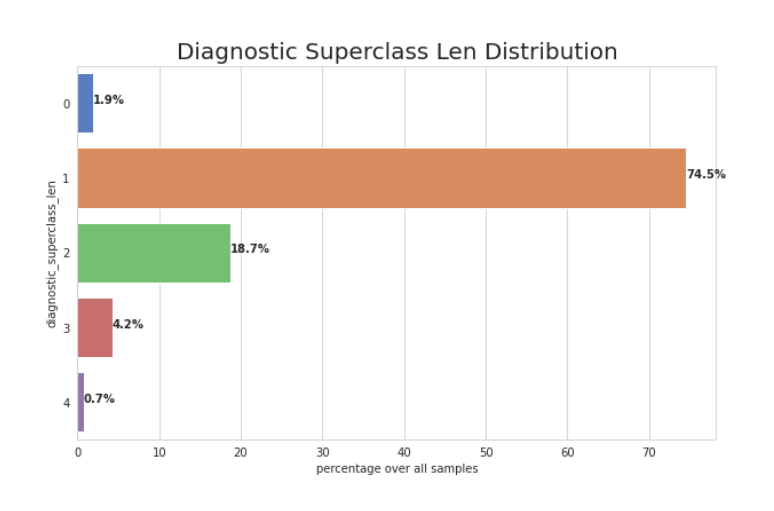

> There could be up to 4 super class for the same ecg record!

#### Meaning of Superclassses
* NORM: Normal ECG
* MI:   Myocardial Infarction, a myocardial infarction (MI), commonly known as a heart attack, occurs when blood flow decreases or stops to a part of the heart, causing damage to the heart muscle [Reference](https://en.wikipedia.org/wiki/Myocardial_infarction)
* STTC: ST/T Change, ST and T wave changes may represent cardiac pathology or be a normal variant. Interpretation of the findings, therefore, depends on the clinical context and presence of similar findings on prior electrocardiograms.[Reference](https://www.uptodate.com/contents/ecg-tutorial-st-and-t-wave-changes)
* CD:   Conduction Disturbance. Your heart rhythm is the way your heart beats. Conduction is how electrical impulses travel through your heart, which causes it to beat. Some conduction disorders can cause arrhythmias, or irregular heartbeats. [Reference](https://www.heart.org/en/health-topics/arrhythmia/about-arrhythmia/conduction-disorders)
* HYP:  Hypertrophy, Hypertrophic cardiomyopathy (HCM) is a disease in which the heart muscle becomes abnormally thick (hypertrophied). The thickened heart muscle can make it harder for the heart to pump blood. [Reference](https://www.mayoclinic.org/diseases-conditions/hypertrophic-cardiomyopathy/symptoms-causes/syc-20350198)

- NORM: 정상 심전도
- MI: 심근경색, 흔히 심장마비로 알려진 심근경색(MI)은 심장 일부에 혈류가 감소하거나 중단되어 심장 근육에 손상을 일으킬 때 발생합니다
- STTC: ST/T 변화, ST 및 T파 변화는 심장 병리를 나타내거나 정상적인 변형일 수 있습니다. 따라서 이 소견의 해석은 임상적 맥락과 이전 심전도에서 유사한 소견이 있었는지에 따라 달라집니다
- CD: 전도 장애. 심장 리듬은 심장이 뛰는 방식입니다. 전도는 전기 자극이 심장을 통해 이동하여 심장을 뛰게 하는 방식입니다. 일부 전도 장애는 부정맥 또는 불규칙한 심장 박동을 유발할 수 있습니다.
- HYP: 비대증, 비후성 심근증(HCM)은 심장 근육이 비정상적으로 두꺼워지는(비대해지는) 질환입니다. 심장 근육이 두꺼워지면 심장이 혈액을 펌프질하기가 더 어려워질 수 있습니다.

### Number of Subclass per ECG record
- 이 과정은 특정 심전도 레코드가 여러 하위 진단 클래스를 가지는지를 파악하고, 이 정보를 통해 더 세분화된 분석을 수행하거나 다중 라벨 분류 문제를 해결하는 데 도움이 됩니다.

In [ ]:
# SCP-ECG 진단 코드를 하위 클래스로 집계하는 함수를 정의합니다.
def aggregate_subclass_diagnostic(y_dic):
    tmp = []  # 임시 리스트를 생성합니다.
    for key in y_dic.keys():  # 주어진 진단 코드의 키들을 순회합니다.
        if key in agg_df.index:  # 만약 키가 agg_df의 인덱스에 존재한다면,
            # 해당 진단 코드의 하위 클래스를 임시 리스트에 추가합니다.
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))  # 중복을 제거한 리스트를 생성합니다.
    ret = ['sub_'+r for r in ret]  # 하위 클래스와 상위 클래스 컬럼을 구별하기 위해 접두사를 추가합니다.
    return ret

# 각 심전도 레코드에 대한 진단 코드를 하위 클래스로 집계하여 새로운 컬럼에 저장합니다.
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass_diagnostic)

# 각 레코드의 하위 진단 클래스 개수를 저장하는 새로운 컬럼을 추가합니다.
Y['diagnostic_subclass_len'] = Y['diagnostic_subclass'].apply(len)

# 하위 진단 클래스가 여러 개인 레코드를 선택하여 출력합니다.
Y.loc[Y.diagnostic_subclass_len > 1, 'diagnostic_subclass']

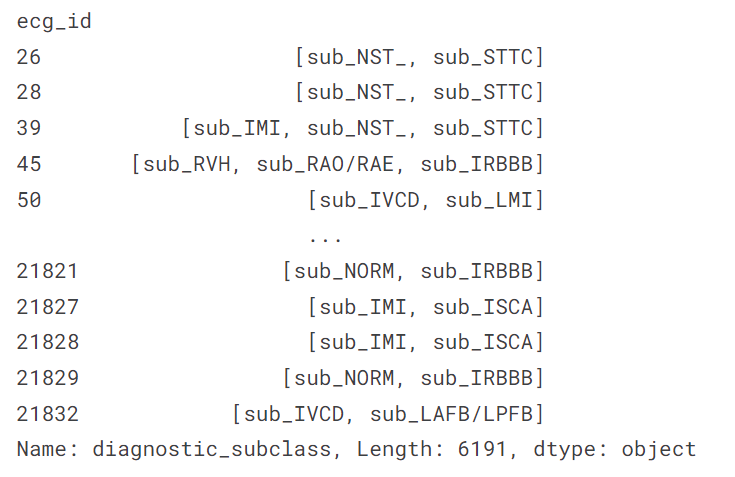

In [ ]:
# 하위 진단 클래스 개수에 대한 값의 분포를 구합니다.
vc = Y['diagnostic_subclass_len'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))

# 바 차트를 그립니다. 각 바의 길이는 전체 샘플에 대한 백분율로 표시됩니다.
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )

ax.set_title("Diagnostic Subclass Length Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnostic_subclass_len")

for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

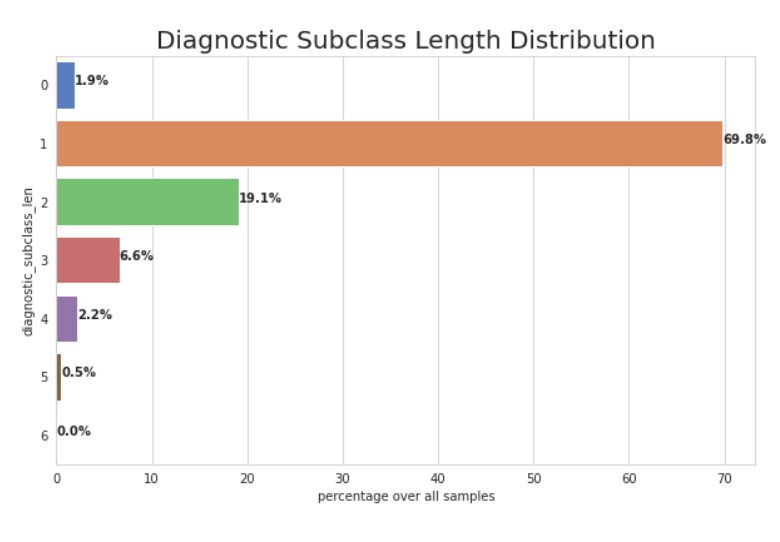

> There could be up to 6 sub class for the same ecg record!
- 이 정보는 데이터 내에서 다중 라벨을 가진 레코드의 비율을 이해하는 데 유용하며, 복잡한 진단을 가진 레코드를 식별하는 데 도움이 될 수 있습니다.

### 우리팀에서는
- diagnostic 값이 없는 'AFIB(심박세동)' 코드가 진단코드 리스트안에 있는지 확인해서 있으면 1, 없으면 0으로 라벨링 해야한다.
- 두 CSV 파일(ptbxl_database, scp_statements)에 들어있는 컬럼 및 데이터 모두 빨리 외워야하지 않을까.

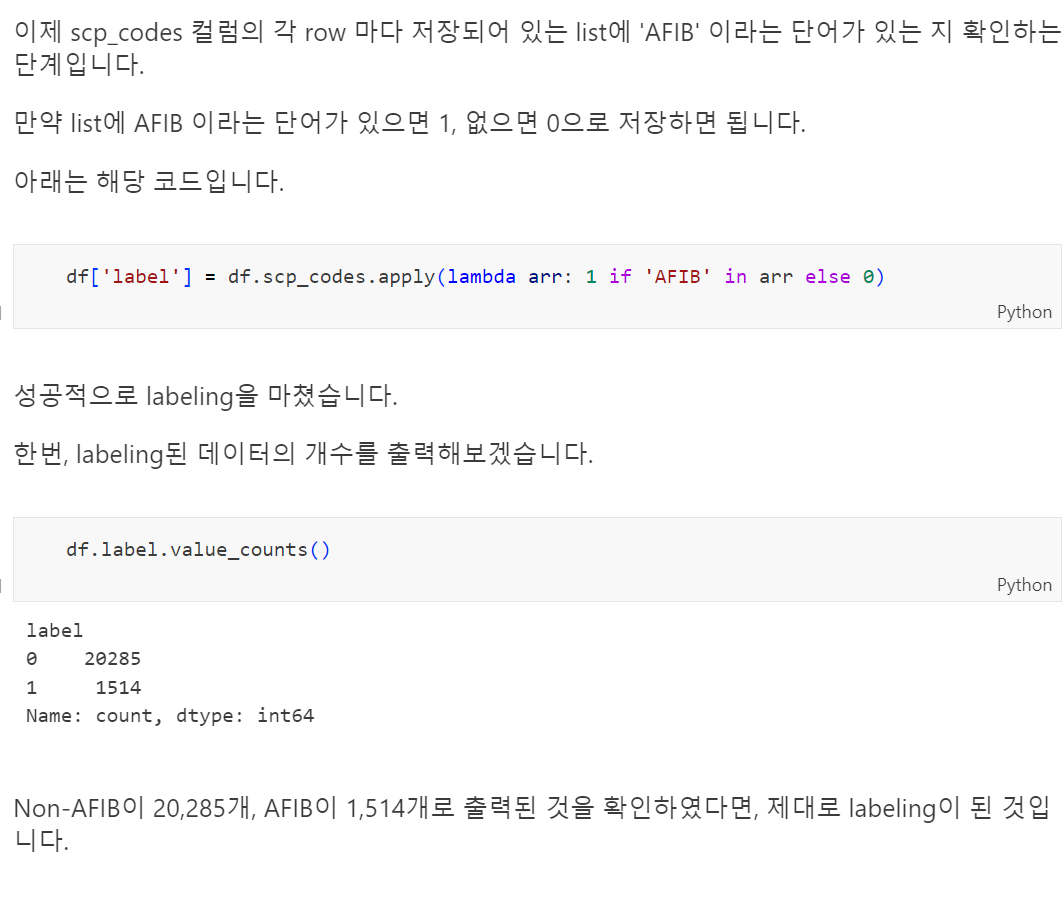

In [ ]:
# Y 데이터프레임의 모든 컬럼 이름을 리스트로 변환하고 출력합니다.
Y.columns.tolist()

'patient_id',
 'age',
 'sex',
 'height',
 'weight',
 'nurse',
 'site',
 'device',
 'recording_date',
 'report',
 'scp_codes',
 'heart_axis',
 'infarction_stadium1',
 'infarction_stadium2',
 'validated_by',
 'second_opinion',
 'initial_autogenerated_report',
 'validated_by_human',
 'baseline_drift',
 'static_noise',
 'burst_noise',
 'electrodes_problems',
 'extra_beats',
 'pacemaker',
 'strat_fold',
 'filename_lr',
 'filename_hr',
 'diagnostic_superclass',
 'diagnostic_superclass_len',
 'diagnostic_subclass',
 'diagnostic_subclass_len'

## Reformat Data for EDA

- 첫번째 코드는 굳이 왜 저렇게 다시 상위, 하위 합치는 지 이해가 안된다.
- 두번째 코드는 아직 어떤 코드인지 이해가 안된다. 내가 아는 그 폴드 맞는건가.

In [ ]:
# Y 데이터프레임의 'diagnostic_superclass' 컬럼의 모든 값들을 하나의 시리즈로 통합합니다.
all_superclass = pd.Series(np.concatenate(Y['diagnostic_superclass'].values))

# Y 데이터프레임의 'diagnostic_subclass' 컬럼의 모든 값들을 하나의 시리즈로 통합합니다.
all_subclass = pd.Series(np.concatenate(Y['diagnostic_subclass'].values))

superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()

# 상위 클래스와 하위 클래스의 컬럼을 통합합니다.
update_cols = np.concatenate([superclass_cols, subclass_cols])  # 메타 데이터 컬럼들을 추가합니다.

# 추가적인 메타 데이터 컬럼들을 리스트로 생성합니다.
meta_cols = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']  # 필요에 따라 더 많은 컬럼을 추가할 수 있습니다.

In [ ]:
# ClassUpdate 클래스는 각 데이터 포인트에 대한 진단 상위 클래스와 하위 클래스를 표시하는 새로운 컬럼을 데이터에 추가합니다.
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols  # 업데이트 할 컬럼 이름을 인스턴스 변수로 저장합니다.

    def __call__(self, row):
        # 주어진 행의 'diagnostic_superclass' 컬럼의 각 항목에 대해 반복합니다.
        for sc in row['diagnostic_superclass']:
            row[sc] = 1  # 상위 클래스에 해당하는 컬럼에 1을 설정합니다.

        # 주어진 행의 'diagnostic_subclass' 컬럼의 각 항목에 대해 반복합니다.
        for sc in row['diagnostic_subclass']:
            row[sc] = 1  # 하위 클래스에 해당하는 컬럼에 1을 설정합니다.
            
        return row  # 업데이트 된 행을 반환합니다.


# 교차 검증 폴드에 따라 데이터를 필터링하고, 클래스 정보를 업데이트하는 함수입니다.
def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds) > 0, '# of provided folds should longer than 1'  # 주어진 폴드의 수가 1보다 커야 함을 확인합니다.
    
    # y 데이터프레임의 'strat_fold' 컬럼을 사용하여 필터를 생성합니다.
    filt = np.isin(y.strat_fold.values, folds)
    
    # 필터를 적용하여 선택된 x와 y 데이터를 추출합니다.
    x_selected = x[filt]
    y_selected = y[filt]
    
    # update_cols에 있는 각 컬럼에 대해 y_selected의 해당 컬럼을 0으로 초기화합니다.
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)  # ClassUpdate 인스턴스를 생성합니다.
    y_selected = y_selected.apply(cls_updt, axis=1)  # apply 메소드를 사용하여 각 행에 대해 ClassUpdate를 적용합니다.
    
    # 선택된 특성 컬럼과 업데이트된 클래스 컬럼, 그리고 'strat_fold' 컬럼을 포함하는 y_selected를 반환합니다.
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]


In [ ]:
x_all, y_all = get_data_by_folds(np.arange(1, 11), X, Y, update_cols, meta_cols)

In [ ]:
y_all

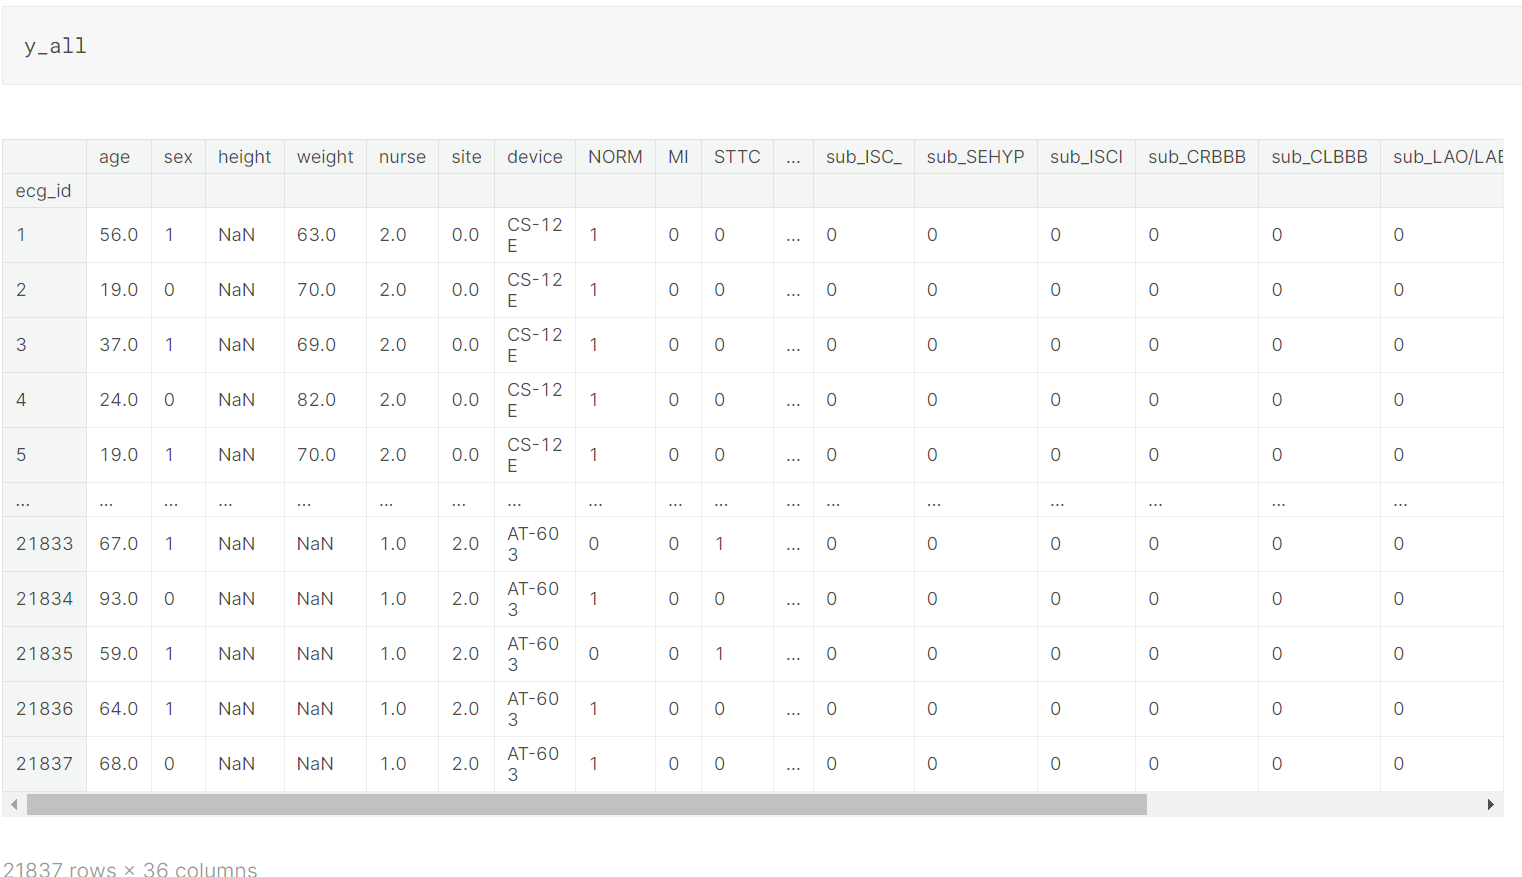

### Superclass Distribution

In [ ]:
vc = y_all[superclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )

ax.set_title("Diagnositic Superclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic superclass")

for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

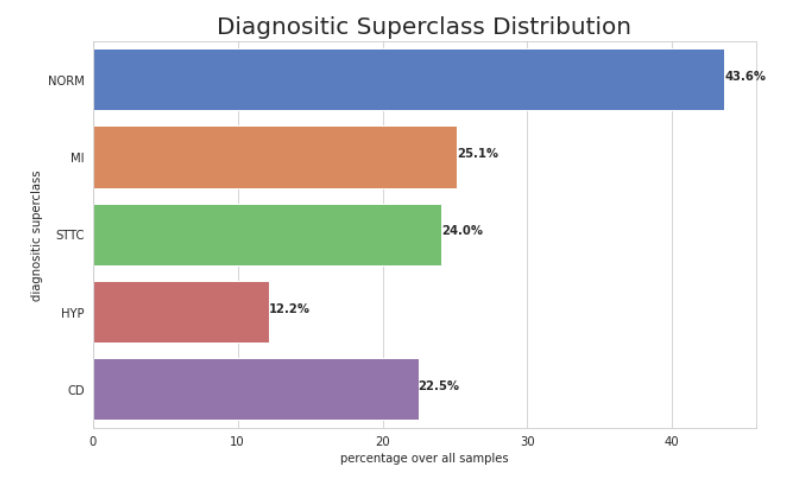

### Subclass Distribution

In [ ]:
vc = y_all[subclass_cols].sum(axis=0)

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )

ax.set_title("Diagnositic Subclass Distribution", fontsize=20)
ax.set_xlabel ("percentage over all samples")
ax.set_ylabel ("diagnositic subclass")

for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

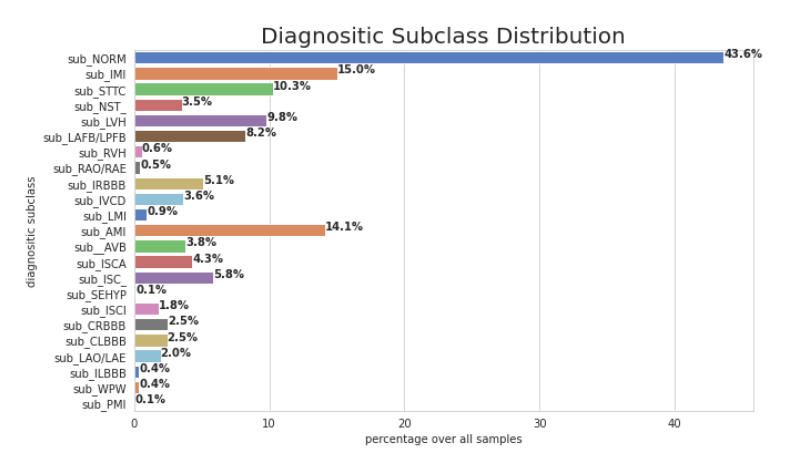

### Subclass Distribution of each Superclass

In [ ]:
for superclass in superclass_cols:
    
    vc = y_all.loc[y_all[superclass] == 1][subclass_cols].sum(axis=0)
    
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x=vc.values/y_all.shape[0]*100., y=vc.index, ci=None, palette="muted",orient='h' )
    ax.set_title("{} Subclass Distribution".format(superclass), fontsize=20)
    ax.set_xlabel ("percentage over all samples")
    ax.set_ylabel ("diagnositic subclass")
    for rect in ax.patches:
        ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

- 캐글 코드 상에는 "{} Subclass Distribution".format(superclass) 으로 되어있는데 "Distribution of Subclasses within '{}'".format(superclass) 로 표현하는 게 더 의미 전달이 잘 된다.

In [ ]:
meta_cols # ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']

### Per Superclass Age Distribution
- NORM 제외하면 60~80대가 압도적으로 많다.

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Age Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1]['age']   
    sns.distplot(data, label=superclass)


plt.legend(loc='upper left')
plt.show()

### Per Superclass Height Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Height Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1][['height']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

### Per Superclass Weight Distribution

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Height Distributions of Different Superclass')

for superclass in superclass_cols:
    data = y_all.loc[y_all[superclass] == 1][['weight']]
    sns.distplot(data, label=superclass)

plt.legend(labels=superclass_cols, loc='upper left')
plt.show()

### Per Sex Superclass Distribution
- 대부분 진단의 경우 SEX=0이 더 많은데 STTC의 경우에만 성별차가 거의 없거나 역전

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
    
ax.set_title("Diagnositic Superclass Distribution of Different Sex", fontsize=20)

# 모든 성별에 대한 정보를 저장할 리스트를 초기화합니다.
all_index, all_count, all_values = [], [], []

# y_all 데이터프레임에서 성별의 고유값을 순회합니다.
for sex in y_all.sex.unique():
    # 현재 성별에 해당하는 데이터에서 상위 진단 클래스의 빈도를 계산합니다.
    vc = y_all.loc[y_all.sex == sex][superclass_cols].sum(axis=0)
    # 계산된 빈도수를 리스트에 추가합니다.
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)  # 전체 샘플에 대한 백분율로 변환합니다.
    all_values += [sex]*len(vc)  # 성별 레이블을 추가합니다.

# 결과 데이터를 데이터프레임으로 변환합니다.
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['sex'] = all_values

    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="sex",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

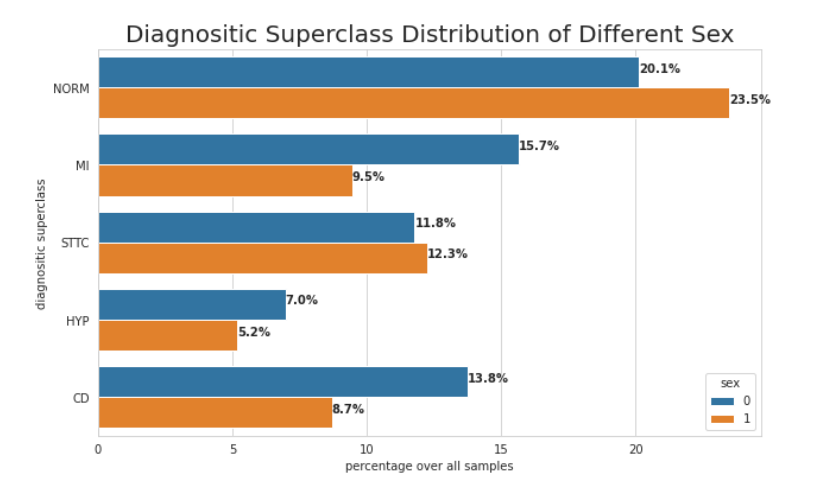


### Per Nurse Superclass Distribution
- Nurse =0 또는 1.0이 대다수

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Nurse", fontsize=20)

all_index, all_count, all_values = [], [], []
for nurse in y_all.nurse.unique():
    vc = y_all.loc[y_all.nurse == nurse][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [nurse]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['nurse'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="nurse",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold')

### Per Site Superclass Distribution
- Site=0,1,2 가 압도적으로 많음.

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,50))
    
ax.set_title("Diagnositic Superclass Distribution of Different Site", fontsize=20)

all_index, all_count, all_values = [], [], []
for site in y_all.site.unique():
    vc = y_all.loc[y_all.site == site][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [site]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['site'] = all_values
    
ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="site",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

### Per Device Superclass Distribution
- CS100 3이 모든 클래스에서 가장 많음

In [ ]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,20))
    
ax.set_title("Diagnositic Superclass Distribution of Different Device", fontsize=20)

all_index, all_count, all_values = [], [], []
for device in y_all.device.unique():
    vc = y_all.loc[y_all.device == device][superclass_cols].sum(axis=0)
    all_index += list(vc.index)
    all_count += list(vc.values/y_all.shape[0]*100.)
    all_values += [device]*len(vc)
    #print(all_sex)
    
df = pd.DataFrame()
df['diagnositic superclass'] = all_index
df['percentage over all samples'] = all_count
df['device'] = all_values

ax = sns.barplot(data=df, x="percentage over all samples", y="diagnositic superclass", hue="device",ci=None, orient='h')
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.2f%%"% rect.get_width(), weight='bold')

### Per Superclass ECG Examples

In [ ]:
# 샘플 수를 정의합니다.
sample_num = 5

# 각 상위 진단 클래스에 대해 반복합니다.
for superclass in superclass_cols:
    # 현재 상위 진단 클래스에 해당하는 데이터를 필터링합니다.
    filt = y_all[superclass] == 1
    y_selected = y_all.loc[filt]
    x_selected = x_all[filt]
    
    # 각 클래스에서 지정된 수의 샘플에 대해 반복합니다.
    for i in range(sample_num):
        y_ = y_selected.iloc[i]  # 메타데이터 선택
        x_ = x_selected[i]  # 신호 데이터 선택
        
        # 메타데이터와 신호 데이터의 형태를 확인하고, 실패할 경우 단언문이 중단됩니다.
        # print(y_.shape, x_.shape); assert False
        
        # 각 신호 채널에 대한 서브플롯을 생성합니다.
        bar, axes = plt.subplots(x_.shape[1], 1, figsize=(10,10))
        # 차트의 제목을 설정합니다. 여기서는 메타데이터 정보를 포함합니다.
        title = "Superclass = {}, Age = {}, Height = {}, Weight = {}, Sex = {}, Nurse = {}, Site = {}, Device = {}".format(
            superclass, y_['age'], y_['height'], y_['weight'], y_['sex'], y_['nurse'], y_['site'], y_['device']
        )
        axes[0].set_title(title, fontsize=15)
        
        # 각 채널의 신호 데이터에 대해 선형 플롯을 그립니다.
        for c in np.arange(x_.shape[1]):
            sns.lineplot(x=np.arange(x_.shape[0]), y=x_[:, c], ax=axes[c])
        
        # 플롯의 레이아웃을 조정하고 표시합니다.
        plt.tight_layout()
        plt.show()
        
        # 디버깅을 위한 단언문: 프로세스를 중단합니다.
        # assert False

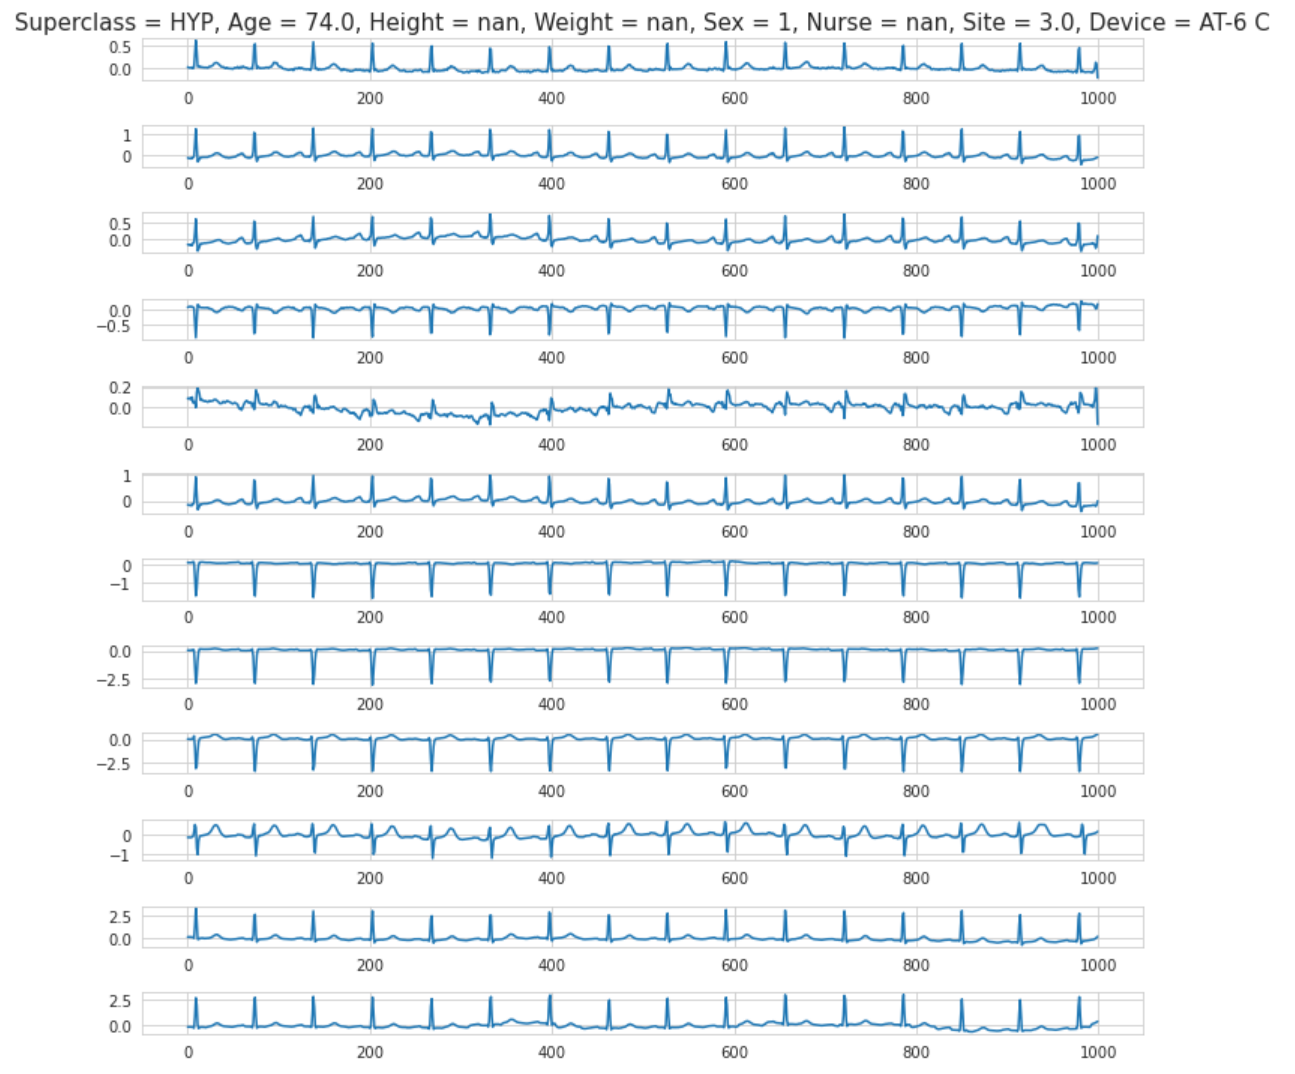

# Train-Valid-Test Set Splitting

According to the source of the [dataset](https://physionet.org/content/ptb-xl/1.0.1/), there are recommended ***stratified 10-folds***, where the ***same patients are kept within the same folds***. Moreover, ***9th fold and 10th are of higher quality, which are recommeded to be used as validation set and test set***. 


> 5. Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

Here, I will split compile fold 1-8 as train sets, fold 9 as validation set, and fold 10 as test set.

### Train

In [ ]:
x_train, y_train = get_data_by_folds(np.arange(1, 9), X, Y, update_cols, meta_cols)
print('data shape', x_train.shape) # data shape (17441, 1000, 12)
y_train

### Valid

In [ ]:
x_valid, y_valid = get_data_by_folds([9], X, Y, update_cols, meta_cols)
print('data shape', x_valid.shape) # data shape (2193, 1000, 12)
y_valid

### Test

In [ ]:
x_test, y_test = get_data_by_folds([10], X, Y, update_cols, meta_cols)
print('data shape', x_test.shape) # data shape (2203, 1000, 12)
y_test

#### 심전도 데이터의 메타데이터(y_train)를 CSV 파일로 저장하고, 연관된 신호 데이터(x_train)를 별도의 CSV 파일로 저장

In [ ]:
# ECG 데이터의 고유 식별자를 위한 컬럼 이름을 정의합니다.
id_cols = ['ecg_id']

# ECG 신호 데이터의 각 채널에 대한 컬럼 이름을 생성합니다. 12개의 채널이 있다고 가정합니다.
channel_cols = ['channel-{}'.format(i) for i in range(12)]


y_train.to_csv('train_meta.csv', index=True)

# y_train 신호 데이터를 저장할 새로운 데이터프레임을 초기화합니다.
# 이 데이터프레임은 ECG ID와 12개 채널의 신호 값을 포함할 것입니다.
y_train_signal = pd.DataFrame(columns=id_cols+channel_cols, index=np.arange(y_train.shape[0]*1000), dtype=np.float32)


# ECG ID와 신호 값을 저장할 리스트를 초기화합니다.
ecg_ids = []
signals = []


# y_train의 모든 ECG ID에 대해 반복합니다.
for i, ecg_id in enumerate(y_train.index.values):
    # 해당 ECG ID를 1000번 반복하여 y_train_signal 데이터프레임의 'ecg_id' 컬럼에 할당합니다.
    # 여기서는 각 ECG 신호가 1000개의 시간 포인트를 가진다고 가정합니다.
    y_train_signal.loc[i*1000:(i+1)*1000-1, 'ecg_id'] = [ecg_id]*1000
    # x_train에서 해당 ECG ID의 신호 데이터를 추출하여 채널 컬럼에 할당합니다.
    y_train_signal.loc[i*1000:(i+1)*1000-1, channel_cols] = x_train[i,:,:]

# y_train_signal 데이터프레임의 'ecg_id' 컬럼을 정수형으로 변환합니다.
y_train_signal['ecg_id'] = y_train_signal['ecg_id'].astype(np.int)

y_train_signal.to_csv('train_signal.csv', index=False)

display(y_train) 
display(y_train_signal)

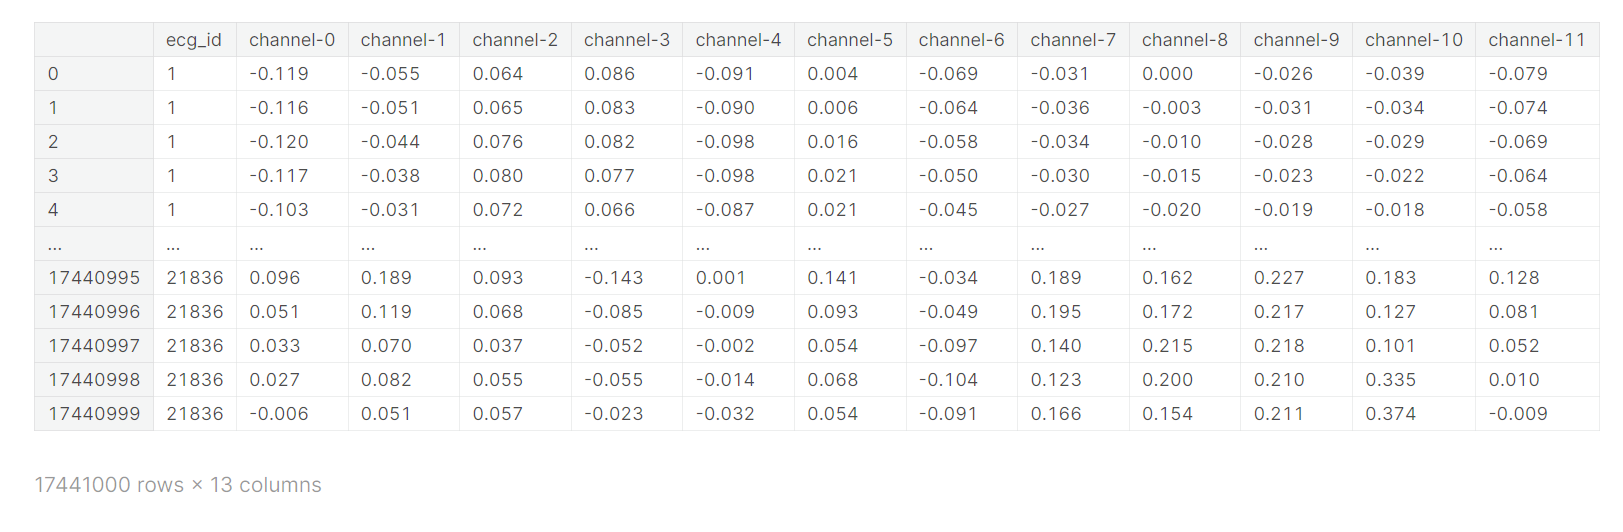

In [ ]:
y_valid.to_csv('valid_meta.csv', index=True)
y_valid_signal = pd.DataFrame(columns=id_cols+channel_cols, index=np.arange(y_valid.shape[0]*1000), dtype=np.float32)

ecg_ids = []
signals = []
for i, ecg_id in enumerate(y_valid.index.values):
    y_valid_signal.loc[i*1000:(i+1)*1000-1, 'ecg_id'] = [ecg_id]*1000
    y_valid_signal.loc[i*1000:(i+1)*1000-1, channel_cols] = x_valid[i,:,:]

y_valid_signal['ecg_id'] = y_valid_signal['ecg_id'].astype(np.int)
y_valid_signal.to_csv('valid_signal.csv', index=False)

display(y_valid) 
display(y_valid_signal)

In [ ]:
y_test.to_csv('test_meta.csv', index=True)
y_test_signal = pd.DataFrame(columns=id_cols+channel_cols, index=np.arange(y_test.shape[0]*1000), dtype=np.float32)

ecg_ids = []
signals = []
for i, ecg_id in enumerate(y_test.index.values):
    y_test_signal.loc[i*1000:(i+1)*1000-1, 'ecg_id'] = [ecg_id]*1000
    y_test_signal.loc[i*1000:(i+1)*1000-1, channel_cols] = x_test[i,:,:]

y_test_signal['ecg_id'] = y_test_signal['ecg_id'].astype(np.int)
y_test_signal.to_csv('test_signal.csv', index=False)

display(y_test) 
display(y_test_signal)

### Note:
* x_train, x_valid, x_test: 12-lead ECG signals for train, valid, and test set.
* y_train, y_valid, y_test: fold number, ecg id, possible feature and possible target columns for modeling.
* Columns that **should be skipped** for modeling:
    * **strat_fold**: kept to be used cross validation within train set
    * **ecg id**: the id for the ecg signal in the raw dataset, kept as a reference
* Possibly Feature columns aside the heart beat signal: ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device']
* Possibly Target columns: All superclass and subclass columns.

# Reference
* [Paper: Wagner, P., Strodthoff, N., Bousseljot, R.-D., Kreiseler, D., Lunze, F.I., Samek, W., Schaeffter, T. (2020), PTB-XL: A Large Publicly Available ECG Dataset. Scientific Data. https://doi.org/10.1038/s41597-020-0495-6](https://www.nature.com/articles/s41597-020-0495-6)